**Import Libraries and Load Cleaned Data

In [11]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

# Load the cleaned dataset
df_cleaned = pd.read_csv('../data/cleaned_diabetes_dataset.csv')

**Split Data

In [12]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert DataFrame to PyTorch tensors
X = torch.tensor(df_cleaned.drop('Diabetes_012', axis=1).values, dtype=torch.float32)
y = torch.tensor(df_cleaned['Diabetes_012'].values, dtype=torch.long)

# Split data into training and remaining dataset with 70% and 30% respectively
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.3, random_state=42)

# Split remaining dataset into validation and testing sets equally (50% each of the remaining data)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

# Create DataLoaders for each set
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


**Minority Class Improvement

In [13]:
# Increase the cost of misclassifying the minority class during training
class_weights = compute_class_weight('balanced', classes=np.unique(y_train.numpy()), y=y_train.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = class_weights.to(device)

**NN Architecture

In [14]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size) 
        self.fc4 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        return out

def train_model(params):
    model = NeuralNet(X_train.shape[1], params['hidden_size'], 3).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

    epoch_losses = []  # List to store average loss per epoch

    for epoch in range(params['num_epochs']):
        model.train()
        total_loss = 0
        num_batches = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        average_loss = total_loss / num_batches
        epoch_losses.append(average_loss)

    return model, epoch_losses

**Hyperparameter Tuning

Hyperparameter Tuning: 100%|█████████████████████████████████████████████████████████████████████| 27/27 [20:36<00:00, 45.79s/it, LR: 0.1, Hidden: 150, Epochs: 15, Acc: 0.8417, Time: 74.62s]


loss {(0.001, 50, 5): [0.9426982063430923, 0.9319631362605739, 0.9272993921159624, 0.9257079139915673, 0.9237111874958417], (0.001, 50, 10): [0.9429982783987716, 0.9320865260588156, 0.92834040177835, 0.9269286559079144, 0.9255735310992679, 0.9208332695832123, 0.9189610731923903, 0.9171747258332399, 0.9139336115175539, 0.9116943520683426], (0.001, 50, 15): [0.9415970129794903, 0.9330486009572003, 0.928096841326705, 0.9260253271970663, 0.9231771027290069, 0.9213203445211187, 0.920737073528874, 0.9161679449167337, 0.9148744660454827, 0.9112886296736228, 0.9078831722285297, 0.9064584672773206, 0.9030877218804918, 0.8977901745486904, 0.8935126487843625], (0.001, 100, 5): [0.9416079078171704, 0.9329330664497238, 0.9283972775613939, 0.9261547477610477, 0.9235418938301705], (0.001, 100, 10): [0.9435013972101984, 0.9336538088643873, 0.9286510610365653, 0.9249421881555437, 0.9232081028362652, 0.9195126559927657, 0.9173282591716663, 0.9116453073690604, 0.9087756793993014, 0.9028023544732515], (0.

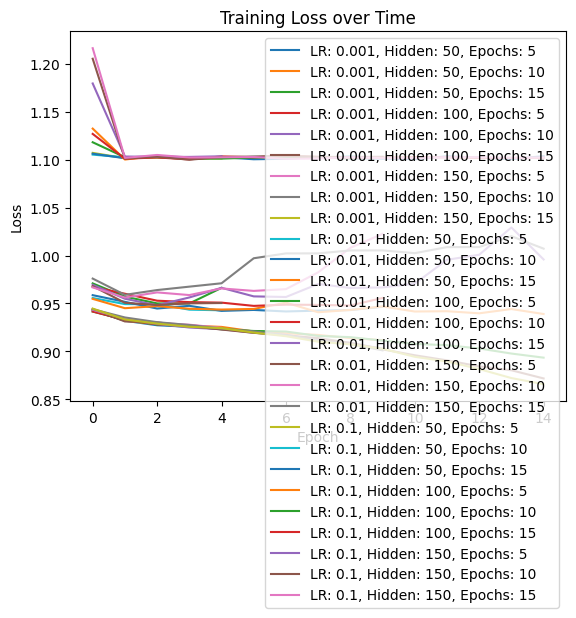

In [15]:
hyperparams = {
    'learning_rate': [0.001, 0.01, 0.1],
    'hidden_size': [50, 100, 150],
    'num_epochs': [5, 10, 15]
}

best_accuracy = 0
best_params = {}
loss_records = {}

# Calculate the total number of iterations
total_iterations = len(hyperparams['learning_rate']) * len(hyperparams['hidden_size']) * len(hyperparams['num_epochs'])

with tqdm(total=total_iterations, desc="Hyperparameter Tuning") as pbar:
    for lr in hyperparams['learning_rate']:
        for hidden_size in hyperparams['hidden_size']:
            for num_epochs in hyperparams['num_epochs']:
                params = {'learning_rate': lr, 'hidden_size': hidden_size, 'num_epochs': num_epochs}
                
                start_time = time.time()  # Start time for the current set of parameters
                model, losses = train_model(params)
                loss_records[(lr, hidden_size, num_epochs)] = losses
                
                # Evaluate the model
                model.eval()
                with torch.no_grad():
                    correct = 0
                    total = 0
                    for inputs, labels in val_loader:
                        outputs = model(inputs)
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()
                accuracy = correct / total

                elapsed_time = time.time() - start_time  # Calculate elapsed time

                # Update best accuracy and parameters if current model is better
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = params

                # Update progress bar
                pbar.update(1)
                pbar.set_postfix_str(f"LR: {lr}, Hidden: {hidden_size}, Epochs: {num_epochs}, Acc: {accuracy:.4f}, Time: {elapsed_time:.2f}s")

# plot losses
for key, losses in loss_records.items():
    plt.plot(losses, label=f'LR: {key[0]}, Hidden: {key[1]}, Epochs: {key[2]}')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.legend()

**Train Best Model

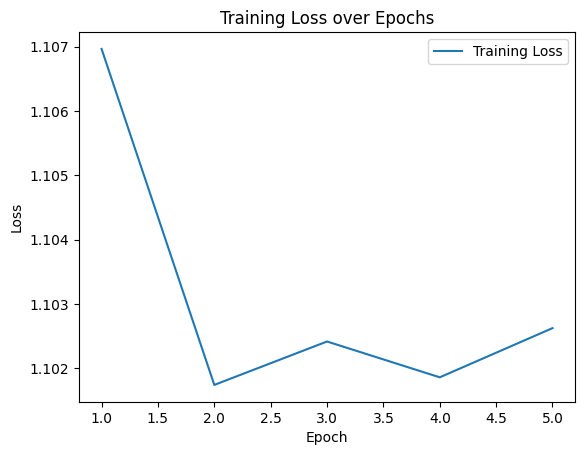

In [56]:
best_model, losses = train_model(best_params)

epochs = range(1, len(losses) + 1)

plt.plot(epochs, losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

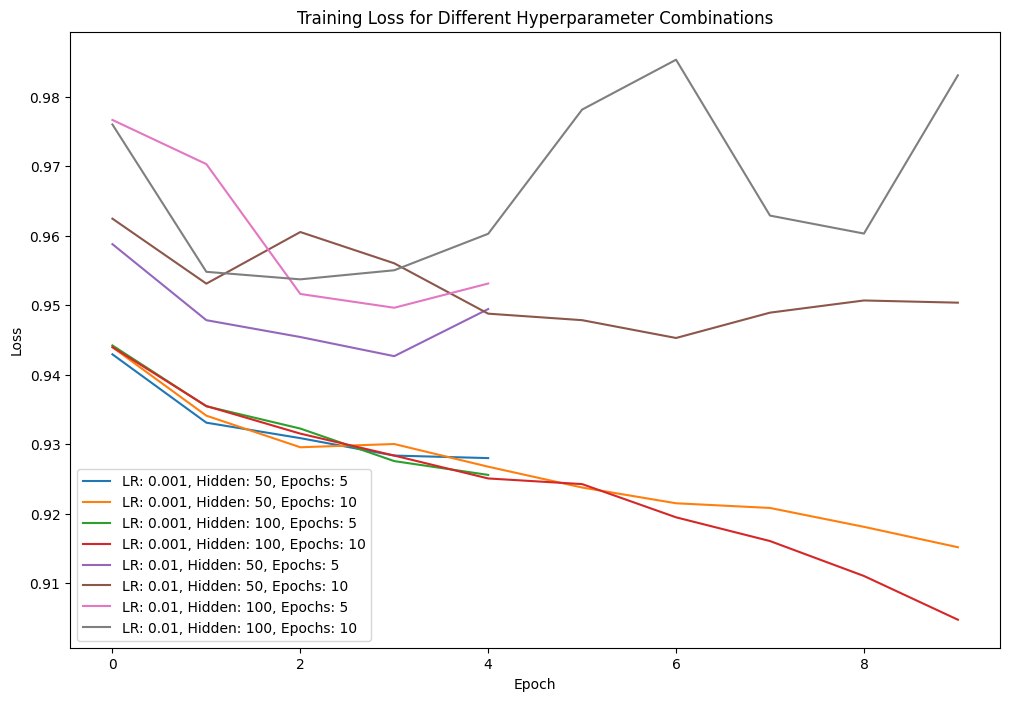

In [60]:
def plot_training_loss(loss_records):
    plt.figure(figsize=(12, 8))

    # Plotting each set of hyperparameters
    for key, losses in loss_records.items():
        plt.plot(losses, label=f'LR: {key[0]}, Hidden: {key[1]}, Epochs: {key[2]}')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss for Different Hyperparameter Combinations')
    plt.legend()
    plt.show()

# Assuming loss_records is the dictionary containing your loss data from the training loop
# You would call the function like this
plot_training_loss(loss_records)

**Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)

    return accuracy, precision, recall, f1

# After training your best_model and creating the test_loader, call this function
accuracy, precision, recall, f1 = evaluate_model(best_model, test_loader)

print(f"Training Accuracy: {best_accuracy}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
